In [1]:
#import nupic
import pandas
import time
import copy
import os
import numpy as np
import math
import datetime
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
import seaborn as sns

import nupic
from nupic.algorithms import anomaly_likelihood
from nupic.frameworks.opf.common_models.cluster_params import getScalarMetricWithTimeOfDayAnomalyParams
from nupic.frameworks.opf.model_factory import ModelFactory
from nab.detectors.base import AnomalyDetector
from nab.util import (absoluteFilePaths, createPath)
#from nupic.data.record_stream import RecordStreamIface

#import stream DataHandles
from pkg_resources import resource_filename
from nupic.data.file_record_stream import FileRecordStream

In [2]:
#file locations
src_path = "C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\csv\DEMAGNET_MAX_SPEED_FILT.csv"
dest_path = "C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\csv\DEMAGNET_MAX_SPEED_FILT_htm.csv"

In [18]:
df_demag =pandas.read_csv("C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\csv\DEMAGNET_MAX_SPEED_FILT.csv")
df_htm_demag = df_demag[["DATE", "DEMAGNET_MAX_SPEED_FILT"]].rename(index=str, columns={"DATE": "timestamp", "DEMAGNET_MAX_SPEED_FILT": "value"})
print(df_htm_demag.info(verbose=True), df_htm_demag.head(5))
#print(df_demag[["IPB.TEMP.BAG", "IPB.TEMP.BULKHEAD"]])

<class 'pandas.core.frame.DataFrame'>
Index: 42708 entries, 0 to 42707
Data columns (total 2 columns):
timestamp    42708 non-null object
value        42708 non-null float64
dtypes: float64(1), object(1)
memory usage: 1001.0+ KB
(None,              timestamp     value
0  2018-04-13 15:33:41  3.683064
1  2018-04-13 15:34:10  4.699998
2  2018-04-13 15:34:15  4.750997
3  2018-04-13 15:34:52  4.158429
4  2018-04-13 15:34:59  5.437248)


CSV file handle Class

In [19]:
#Data Object class to read and transform csv file into Data Object 
class DataFile(object):
  """
  Class for storing and manipulating a single datafile.
  Data is stored in pandas.DataFrame
  """

  def __init__(self, srcPath):
    """
    @param srcPath (string)   Filename of datafile to read.
    """
    self.srcPath = srcPath

    self.fileName = os.path.split(srcPath)[1]

    self.data = pandas.io.parsers.read_csv(self.srcPath,
                                           header=0, parse_dates=[0])


  def write(self, newPath=None):
    """Write datafile to self.srcPath or newPath if given.

    @param newPath (string)   Path to write datafile to. If path is not given,
                              write to source path
    """

    path = newPath if newPath else self.srcPath
    self.data.to_csv(path, index=False)


  def modifyData(self, columnName, data=None, write=False):
    """Add columnName to datafile if data is given otherwise remove
    columnName.

    @param columnName (string)          Name of the column in the datafile to
                                        either add or remove.

    @param data       (pandas.Series)   Column data to be added to datafile.
                                        Data length should be as long as the
                                        length of other columns.

    @param write      (boolean) Flag to choose whether to write modifications to
                                source path.
    """
    if isinstance(data, pandas.Series):
      self.data[columnName] = data
    else:
      if columnName in self.data:
        del self.data[columnName]

    if write:
      self.write()


  def getTimestampRange(self, t1, t2):
    """Given timestamp range, get all records that are within that range.

    @param t1   (int)   Starting timestamp.

    @param t2   (int)   Ending timestamp.

    @return     (list)  Timestamp and value for each time stamp within the
                        timestamp range.
    """
    tmp = self.data[self.data["timestamp"] >= t1]
    ans = tmp[tmp["timestamp"] <= t2]["timestamp"].tolist()
    return ans


  def __str__(self):
    ans = ""
    ans += "path:                %s\n" % self.srcPath
    ans += "file name:           %s\n"% self.fileName
    ans += "data size:         ", self.data.shape()
    ans += "sample line: %s\n" % ", ".join(self.data[0])
    return ans

In [20]:

#delete columns from origin file
csv_orig = DataFile(src_path)

#IPB.TEMP.BULKHEAD,IPB.TEMP.BAG,DEMAGNET_MAX_SPEED_FILT,DATE
csv_orig.modifyData("IPB.TEMP.BULKHEAD")
csv_orig.modifyData("IPB.TEMP.BAG")
csv_orig.data
#csv_orig.write(dest_path)

#create data file object
inputData = DataFile(dest_path)
inputData.data.head()
#inputData.getTimestampRange("2018-04-13 15:36:23", "2018-04-13 17:17:47")

,timestamp,value
0,2018-04-13 15:33:41,3.683064
1,2018-04-13 15:34:10,4.699998
2,2018-04-13 15:34:15,4.750997
3,2018-04-13 15:34:52,4.158429
4,2018-04-13 15:34:59,5.437248


NumentaDetector Class inherits from AnomalyDetector

In [21]:
# Fraction outside of the range of values seen so far that will be considered
# a spatial anomaly regardless of the anomaly likelihood calculation. This
# accounts for the human labelling bias for spatial values larger than what
# has been seen so far.
SPATIAL_TOLERANCE = 0.05


class NumentaDetector(AnomalyDetector):
    #This detector uses an HTM based anomaly detection technique.#
    def __init__(self, *args, **kwargs):
        super(NumentaDetector, self).__init__(*args, **kwargs)
        
        self.model = None
        self.sensorParams = None
        self.anomalyLikelihood = None
        # Keep track of value range for spatial anomaly detection
        self.minVal = None
        self.maxVal = None

    # Set this to False if you want to get results based on raw scores
    # without using AnomalyLikelihood. This will give worse results, but
    # useful for checking the efficacy of AnomalyLikelihood. You will need
    # to re-optimize the thresholds when running with this setting.
        self.useLikelihood = True
  
    def getAdditionalHeaders(self):
        """Returns a list of strings."""
        return ["raw_score"]


    def handleRecord(self, inputData):
        """Returns a tuple (anomalyScore, rawScore).
        Internally to NuPIC "anomalyScore" corresponds to "likelihood_score"
        and "rawScore" corresponds to "anomaly_score". Sorry about that.
        """
        # Send it to Numenta detector and get back the results
        result = self.model.run(inputData)
        # Get the value
        value = inputData["value"]

        # Retrieve the anomaly score and write it to a file
        rawScore = result.inferences["anomalyScore"]

        # Update min/max values and check if there is a spatial anomaly
        spatialAnomaly = False
        if self.minVal != self.maxVal:
            tolerance = (self.maxVal - self.minVal) * SPATIAL_TOLERANCE
            maxExpected = self.maxVal + tolerance
            minExpected = self.minVal - tolerance
            if value > maxExpected or value < minExpected:
                spatialAnomaly = True
        if self.maxVal is None or value > self.maxVal:
            self.maxVal = value
        if self.minVal is None or value < self.minVal:
            self.minVal = value

        if self.useLikelihood:
            # Compute log(anomaly likelihood)
            anomalyScore = self.anomalyLikelihood.anomalyProbability(
                inputData["value"], rawScore, inputData["timestamp"])
            logScore = self.anomalyLikelihood.computeLogLikelihood(anomalyScore)
            finalScore = logScore
        else:
            finalScore = rawScore

        if spatialAnomaly:
            finalScore = 1.0

        return (finalScore, rawScore)


    def initialize(self):
        #How to create the HTM model, you know basicaly the min and max
        #Get config params, setting the RDSE resolution
        self.inputMin=float(self.inputMin)
        self.inputMax=float(self.inputMax)
        
        rangePadding = abs(self.inputMax - self.inputMin) * 0.2

        #best htm parameters for anomaly detection(Timestamp,value)
        #best practise parameters: Return a dict that can be used to create an anomaly model via Model.create
        #modelParams["modelParams"]["sensorParams"]["encoders"]
        #RandomDistributedEncoder
        modelParams = getScalarMetricWithTimeOfDayAnomalyParams(
            metricData=[0],
            minVal=self.inputMin-rangePadding,
            maxVal=self.inputMax+rangePadding,
            minResolution=0.001,
            tmImplementation = "cpp"
        )["modelConfig"]

        self._setupEncoderParams(
            modelParams["modelParams"]["sensorParams"]["encoders"])
    
        #create your HTM model with parameters and given data
        self.model = ModelFactory.create(modelParams)
    
        #OPF for prediction, not used for anomaly detection
        self.model.enableInference({"predictedField": "value"})

        if self.useLikelihood:
            # Initialize the anomaly likelihood object
            numentaLearningPeriod = int(math.floor(self.probationaryPeriod / 2.0))
            self.anomalyLikelihood = anomaly_likelihood.AnomalyLikelihood(
                learningPeriod=numentaLearningPeriod,
                estimationSamples=self.probationaryPeriod-numentaLearningPeriod,
                reestimationPeriod=100
            )

        #setup encoder(expect "timestamp" and "value" as headers)
    def _setupEncoderParams(self, encoderParams):
        # The encoder must expect the NAB-specific datafile headers
        encoderParams["timestamp_dayOfWeek"] = encoderParams.pop("c0_dayOfWeek")
        encoderParams["timestamp_timeOfDay"] = encoderParams.pop("c0_timeOfDay")
        encoderParams["timestamp_timeOfDay"]["fieldname"] = "timestamp"
        encoderParams["timestamp_timeOfDay"]["name"] = "timestamp"
        encoderParams["timestamp_weekend"] = encoderParams.pop("c0_weekend")
        encoderParams["value"] = encoderParams.pop("c1")
        encoderParams["value"]["fieldname"] = "value"
        encoderParams["value"]["name"] = "value"

        self.sensorParams = encoderParams["value"]

In [30]:
#if filelength > 5000, then learning window probationPercent * 5000, else probationPercent*Filelength
ad = NumentaDetector(inputData, 0.1)
ad.initialize()
print("inputMin and inputMAX: " + str(ad.inputMax) + "," +  str(ad.inputMin))
print("minVal and minVal: " + str(ad.minVal) + "," + str( ad.maxVal))
print("Sensor parameter: " + str(ad.sensorParams))
print("Anomaly Likelihood: " + str(ad.anomalyLikelihood))

print(ad.probationaryPeriod)

inputMin and inputMAX: 65.6708606527,-10.5683163031
minVal and minVal: None,None
Sensor parameter: {u'name': 'value', 'resolution': 0.8210372902932307, u'seed': 42, u'fieldname': 'value', u'type': u'RandomDistributedScalarEncoder'}
Anomaly Likelihood: AnomalyLikelihood: 0 deque([], maxlen=8640) None 500.0 250 100
500.0


In [31]:
input_file = csv.DictReader(open(dest_path))


timestamp_list = []
value_list = []
anomaly_score_list = []
raw_score_list = []


for row in input_file:
    #print(datetime.datetime.strptime(row["timestamp"], '%Y-%m-%d %H:%M:%S'))
    row["timestamp"] = datetime.datetime.strptime(row["timestamp"], '%Y-%m-%d %H:%M:%S')
    row["value"] = float(row["value"])
    #print(row)
    anomalyScore, rawScore =  ad.handleRecord(row)
    if anomalyScore == 1:
        print(row)
        print(anomalyScore, rawScore)
    #time.sleep(1)
    timestamp_list.append(row["timestamp"])
    value_list.append(row["value"])
    anomaly_score_list.append(anomalyScore)
    raw_score_list.append(rawScore)
        
df_anomaly = pandas.DataFrame(
    {'timestamp': timestamp_list,
     'value': value_list ,
     'raw score': raw_score_list,
     'anomaly score': anomaly_score_list,
    })

print(df_anomaly)

{'timestamp': datetime.datetime(2018, 4, 13, 15, 34, 15), 'value': 4.75099685913}
(1.0, 1.0)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 34, 59), 'value': 5.43724819629}
(1.0, 0.175)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 35, 14), 'value': 6.34452015201}
(1.0, 0.22499999)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 36, 12), 'value': 7.25890441298}
(1.0, 0.15000001)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 37, 49), 'value': 2.22879367739}
(1.0, 0.075000003)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 38, 56), 'value': 8.02448992976}
(1.0, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 47, 47), 'value': 9.10009339269}
(1.0, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 58, 49), 'value': 10.2765862087}
(1.0, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 15, 59, 28), 'value': -0.768403967551}
(1.0, 0.0)
{'timestamp': datetime.datetime(2018, 4, 13, 18, 17, 1), 'value': 11.512715411}
(1.0, 0.0)
{'timestamp': datetime.datetime(2018, 4, 14, 3

In [ ]:
#doble Dataframe for testing
input_file = csv.DictReader(open(dest_path))
print(input_file)

timestamp_list = []
value_list = []
anomaly_score_list = []
raw_score_list = []


#for row in input_file:
    #print(datetime.datetime.strptime(row["timestamp"], '%Y-%m-%d %H:%M:%S'))
#    row["timestamp"] = datetime.datetime.strptime(row["timestamp"], '%Y-%m-%d %H:%M:%S')
#    row["value"] = float(row["value"])
#    print(row)
#    anomalyScore, rawScore =  ad.handleRecord(row)
#    print(anomalyScore, rawScore)
#    #time.sleep(1)
#    timestamp_list.append(row["timestamp"])
#    value_list.append(row["value"])
#    anomaly_score_list.append(anomalyScore)
#    raw_score_list.append(rawScore)
        
#df_anomaly = pandas.DataFrame(
#    {'timestamp': timestamp_list,
#     'value': value_list ,
#     'raw score': raw_score_list,
#     'anomaly score': anomaly_score_list,
 #   })

#print(df_anomaly)

In [25]:
df_anomaly['anomaly'] = np.where(df_anomaly['anomaly score']>=0.99999, 1, 0)
#df_anomaly['anomaly'] = np.where((df_anomaly['anomaly score']<0.99999) & (df_anomaly['anomaly score'] > 0.5 ), 'yellow', 'green')

if not 'IPB.TEMP.BAG' in df_anomaly.columns:
    df_anomaly = pandas.concat([df_anomaly, df_demag["IPB.TEMP.BAG"]], axis=1)

df_anomaly[df_anomaly['anomaly'] == 1].shape

(28, 6)

KeyError: 'IPB.TEMP.BAG'

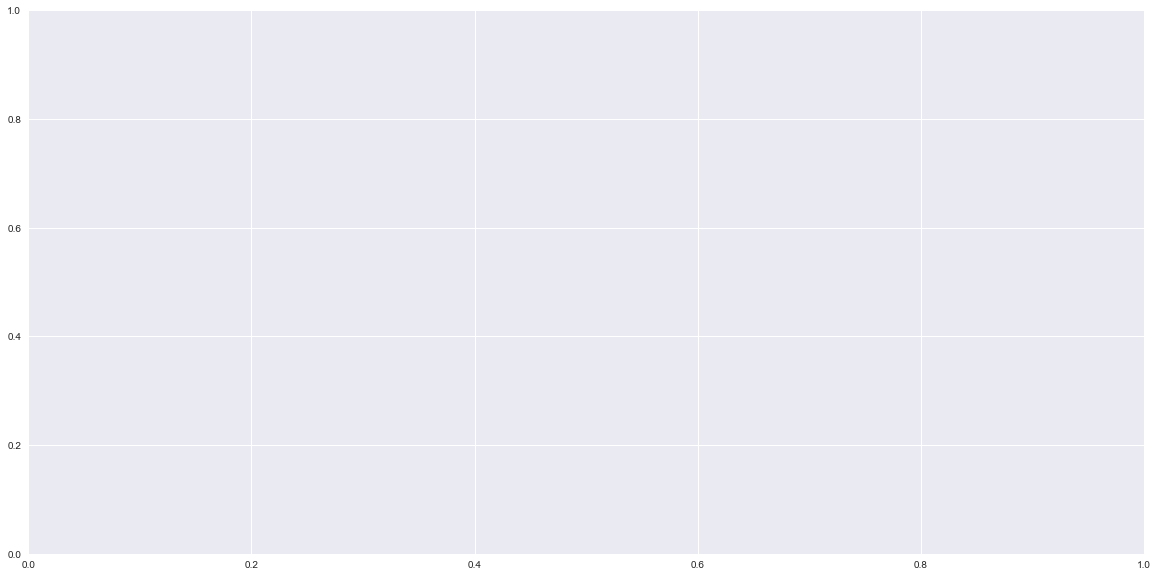

In [24]:
%matplotlib inline
#
fig, ax = plt.subplots(figsize=(20,10))
scatter = ax.scatter(df_anomaly['timestamp'].tolist(), y=df_anomaly['value'] , c=df_anomaly['IPB.TEMP.BAG'], s=100, marker='.', cmap=plt.cm.coolwarm)
clb = fig.colorbar(scatter)
clb.ax.set_title('Temperatur')
plt.xlabel("Date")
plt.ylabel("DEMAGNET_MAX_SPEED_FILT")
plt.title("DEMAGNET_MAX_SPEED_FILT drift over Time")
ax.set_xlim([datetime.date(2018, 4, 13), datetime.date(2018, 5, 4)])

#plot raw score
_, ax = plt.subplots(figsize=(20,10))
ax.scatter(df_anomaly['timestamp'].tolist(),df_anomaly['raw score'])
plt.xlabel("Date")
plt.ylabel("Raw Score")
plt.title("Raw Score of DEMAGNET_MAX_SPEED_FILT")
ax.set_xlim([datetime.date(2018, 4, 13), datetime.date(2018, 5, 4)])


#plot anomaly score
_, ax = plt.subplots(figsize=(20,10))
ax.scatter(df_anomaly['timestamp'].tolist(),df_anomaly['anomaly score'])
plt.xlabel("Date")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Score of DEMAGNET_MAX_SPEED_FILT")
ax.set_xlim([datetime.date(2018, 4, 13), datetime.date(2018, 5, 4)])

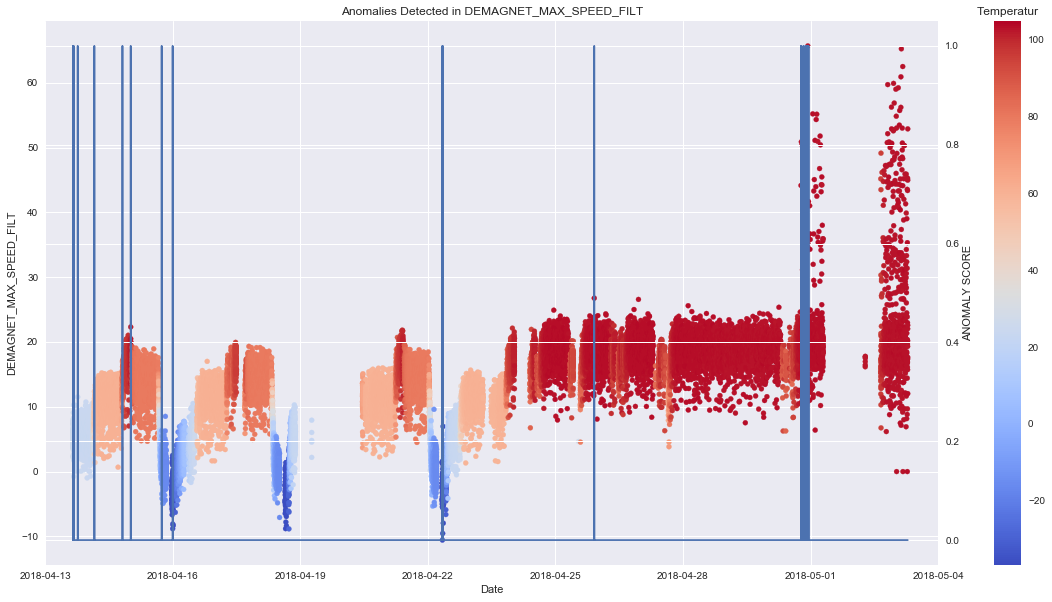

In [12]:
# Define a function for a plot with two y axes
def plot2y(x_data, x_label, y1_data, y1_label, y2_data, y2_label, title, color=None):

    fig, ax1 = plt.subplots(figsize=(20,10))
    scatter = ax1.scatter(x_data, y1_data, c=color,s=100, marker='.', cmap=plt.cm.coolwarm)
    clb = fig.colorbar(scatter)
    clb.ax.set_title('Temperatur')
    # Label axes
    ax1.set_ylabel(y1_label)
    ax1.set_xlabel(x_label)
    ax1.set_title(title)

    # Create the second plot object with the same x-axis
    ax2 = ax1.twinx()
    ax2.plot(x_data, y2_data)
    ax2.set_ylabel(y2_label)
    # Show right frame line
    ax2.spines['right'].set_visible(True)
    ax2.set_xlim([datetime.date(2018, 4, 13), datetime.date(2018, 5, 4)])
    

#create plot
plot2y(x_data = df_anomaly['timestamp'].tolist()
           , x_label = 'Date'
           , y1_data = df_anomaly['value']
           , y1_label = 'DEMAGNET_MAX_SPEED_FILT'
           , y2_data = df_anomaly['anomaly']
           , y2_label = 'ANOMALY SCORE'
           , title = 'Anomalies Detected in DEMAGNET_MAX_SPEED_FILT'
           , color = df_anomaly['IPB.TEMP.BAG'])


       anomaly score  raw score           timestamp          value  anomaly  \
2                1.0      1.000 2018-04-13 15:34:15     107.239364        1   
4                1.0      0.625 2018-04-13 15:34:59     160.745000        1   
5                1.0      0.925 2018-04-13 15:35:14     255.385563        1   
6                1.0      1.000 2018-04-13 15:36:12     382.483965        1   
15               1.0      0.475 2018-04-13 15:37:49      11.071580        1   
20               1.0      0.425 2018-04-13 15:38:56     516.716475        1   
49               1.0      0.525 2018-04-13 15:47:47     753.594202        1   
83               1.0      0.275 2018-04-13 15:58:49    1085.292019        1   
86               1.0      0.375 2018-04-13 15:59:28      -0.453700        1   
528              1.0      0.325 2018-04-13 18:17:01    1525.925419        1   
2284             1.0      0.350 2018-04-14 03:40:35    1881.960510        1   
5298             1.0      0.675 2018-04-14 19:32:03 

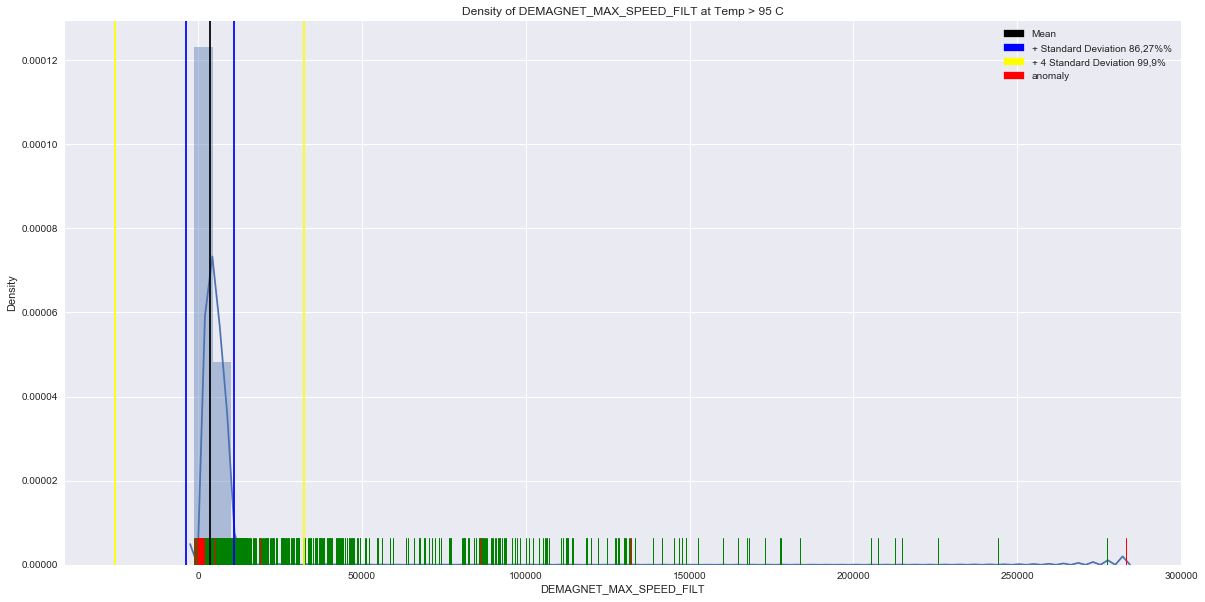

In [61]:
df_anomaly.get_value(24540, 'timestamp')
#df_tempgt95 = df_anomaly[df_anomaly['IPB.TEMP.BAG'] > 95.0]
df_tempgt95['value'] = df_tempgt95.value ** 3

mean = mpatches.Patch(color='black', label='Mean')
std1 = mpatches.Patch(color='blue', label='+ Standard Deviation 86,27%%')
std4 = mpatches.Patch(color='yellow', label='+ 4 Standard Deviation 99,9%')
red = mpatches.Patch(color='red', label='anomaly')

#print(df_tempgt95.head(3))
red_ticks = df_tempgt95[df_tempgt95['anomaly'] == 1]
green_ticks = df_tempgt95[df_tempgt95['anomaly'] < 1]
print(df_tempgt95[df_tempgt95.anomaly == 1])
print("Mean: " + str(np.mean(df_tempgt95.value)))
print("Standard deviation: " + str(np.std(df_tempgt95.value)))
    

#plot distribution of value > 95C°
_, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df_tempgt95.value, hist=True)
sns.rugplot(green_ticks.value, color="green")
sns.rugplot(red_ticks.value, color="red")
ax.set(xlabel='DEMAGNET_MAX_SPEED_FILT', ylabel='Density', title="Density of DEMAGNET_MAX_SPEED_FILT at Temp > 95 C")
ax.axvline(np.mean(df_tempgt95.value), color="black")
ax.axvline((np.mean(df_tempgt95.value) + np.std(df_tempgt95.value)), color="blue")
ax.axvline((np.mean(df_tempgt95.value) - np.std(df_tempgt95.value)), color="blue")
ax.axvline((np.mean(df_tempgt95.value) + 4 * np.std(df_tempgt95.value)), color="yellow")
ax.axvline((np.mean(df_tempgt95.value) - 4 * np.std(df_tempgt95.value)), color="yellow")
ax.legend(handles=[mean, std1, std4, red])

In [13]:
df_tempgt95['log_value'] = (df_tempgt95.value ** 3)
df_tempgt95

plot2y(x_data = df_tempgt95['timestamp'].tolist()
           , x_label = 'Date'
           , y1_data = df_tempgt95['log_value']
           , y1_label = 'DEMAGNET_MAX_SPEED_FILT'
           , y2_data = df_tempgt95['anomaly']
           , y2_label = 'ANOMALY SCORE'
           , title = 'Anomalies Detected in DEMAGNET_MAX_SPEED_FILT'
           , color = df_tempgt95['IPB.TEMP.BAG'])

NameError: name 'df_tempgt95' is not defined

In [14]:
def plot_anomaly_context(data, x_label, y_label, title, start, end):
    
    
    df_anomaly_context = data.iloc[start:end]
    df_anomaly_context.reset_index(level=0, inplace=True)
    
    red_patch = mpatches.Patch(color='red', label='Anomaly')
    green_patch = mpatches.Patch(color='green', label='Normal')
    blue_patch = mpatches.Patch(color='blue', label='Context Window', alpha=0.1)
    
    
    #plot full data, anomalies and context window
    df_anomaly_no = data[data['anomaly'] == 0]
    df_anomaly_yes = data[data['anomaly'] == 1]

    fig, ax1 = plt.subplots(figsize=(20,10))
    ax1.scatter(df_anomaly_no['timestamp'].tolist(), df_anomaly_no['value'], c='green',s=100, marker='.', zorder=1)
    ax1.scatter(df_anomaly_yes['timestamp'].tolist(), df_anomaly_yes['value'], c='red',s=100, marker='.', zorder=2)
    ax1.set_ylabel("DEMAGNET_MAX_SPEED_FILT")
    ax1.set_xlabel("Date")
    ax1.set_title("Detected Anomaly Points")
    ax1.set_xlim([datetime.date(2018, 4, 13), datetime.date(2018, 5, 4)])
    ax1.axvspan(data.get_value(start, 'timestamp'), data.get_value(end, 'timestamp'), facecolor='b', alpha=0.1  )
    ax1.legend(handles=[green_patch, red_patch, blue_patch])
      
    
    _, ax2 = plt.subplots(figsize=(20,10))
    ax2.bar(df_anomaly_context['index'], df_anomaly_context['value'], 
        color=['red' if row['anomaly'] == 1 else 'green' for _,row in df_anomaly_context.iterrows()])
    ax2.set_ylabel(y_label)
    ax2.set_xlabel(x_label)
    ax2.set_title(title)
    plt.legend(handles=[green_patch, red_patch])


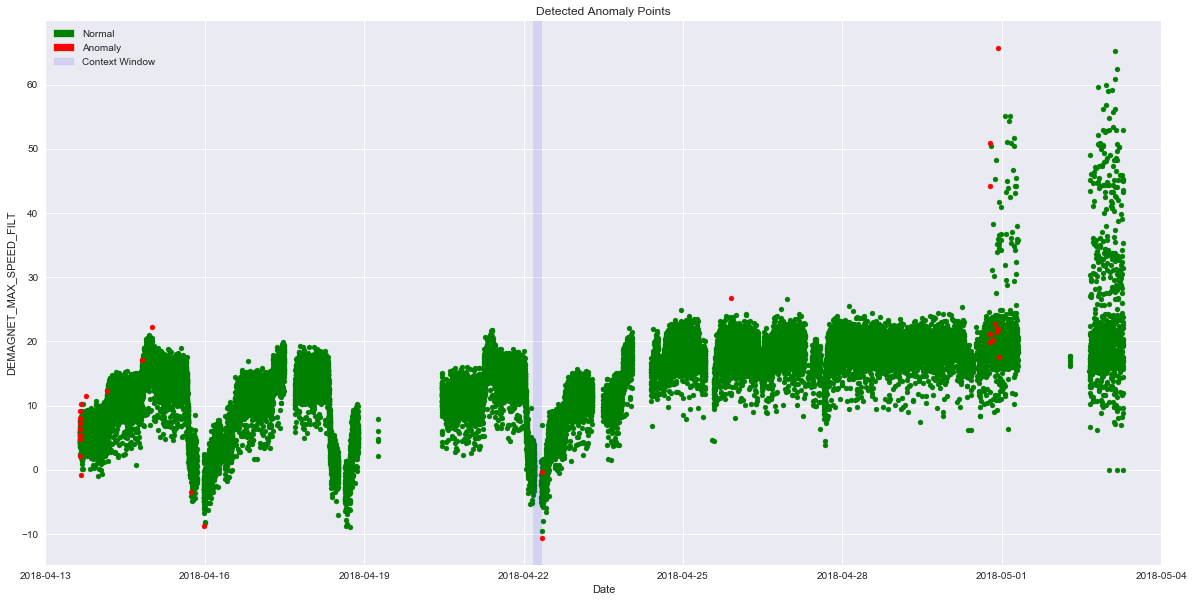

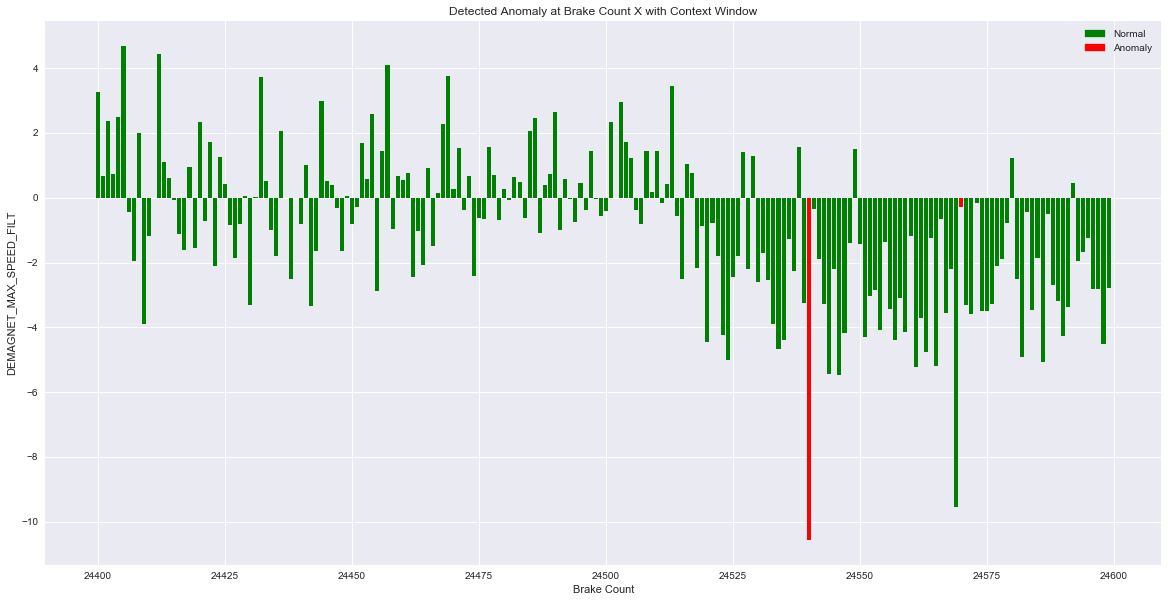

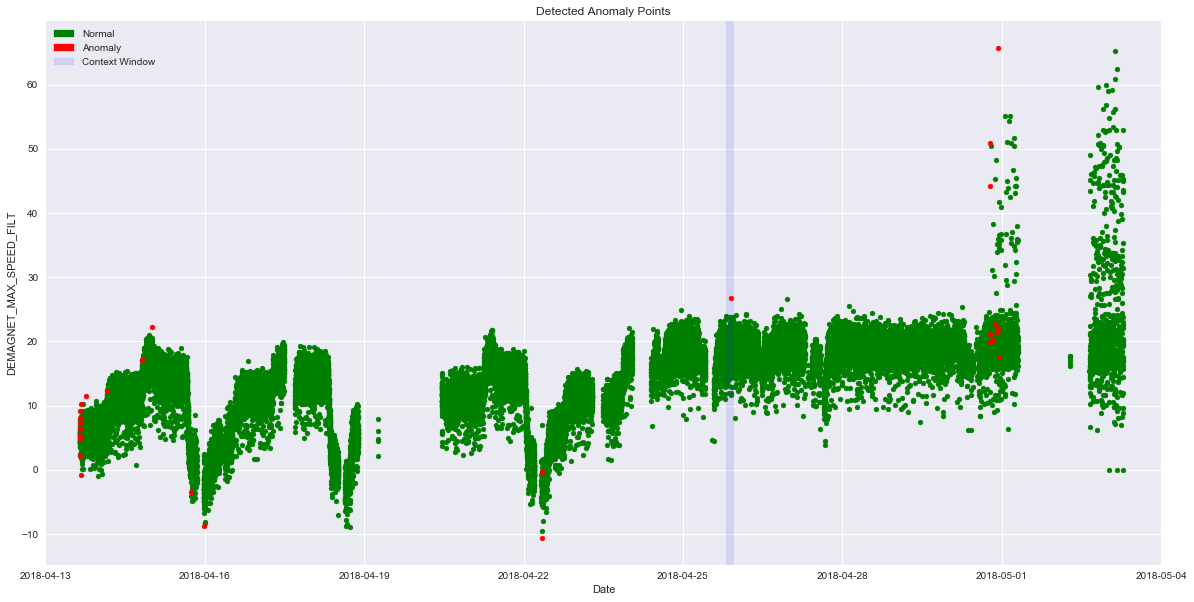

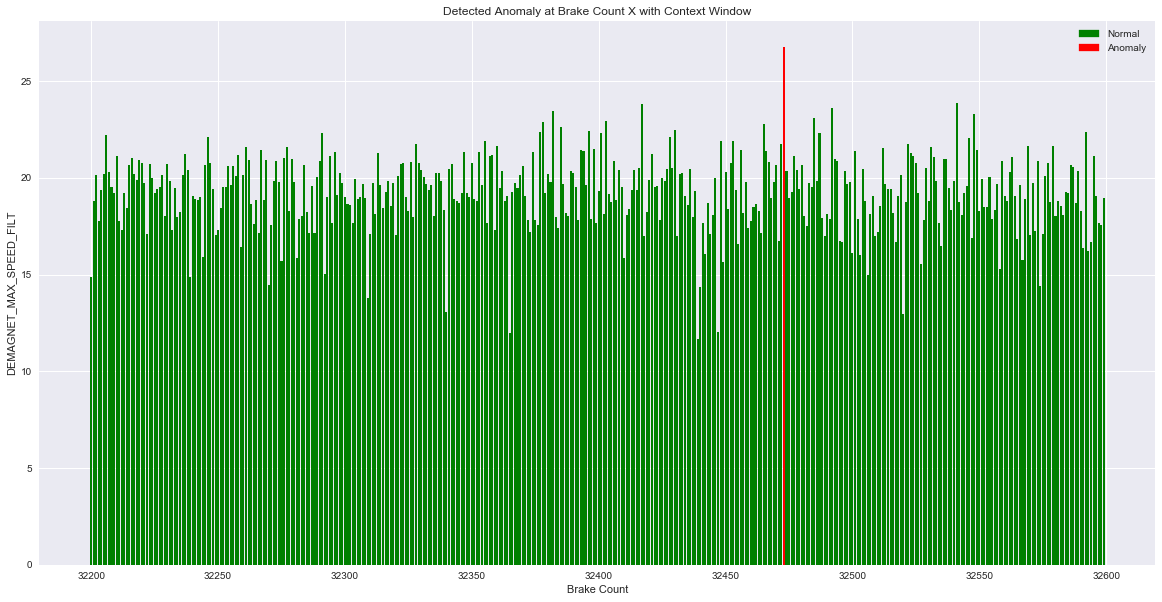

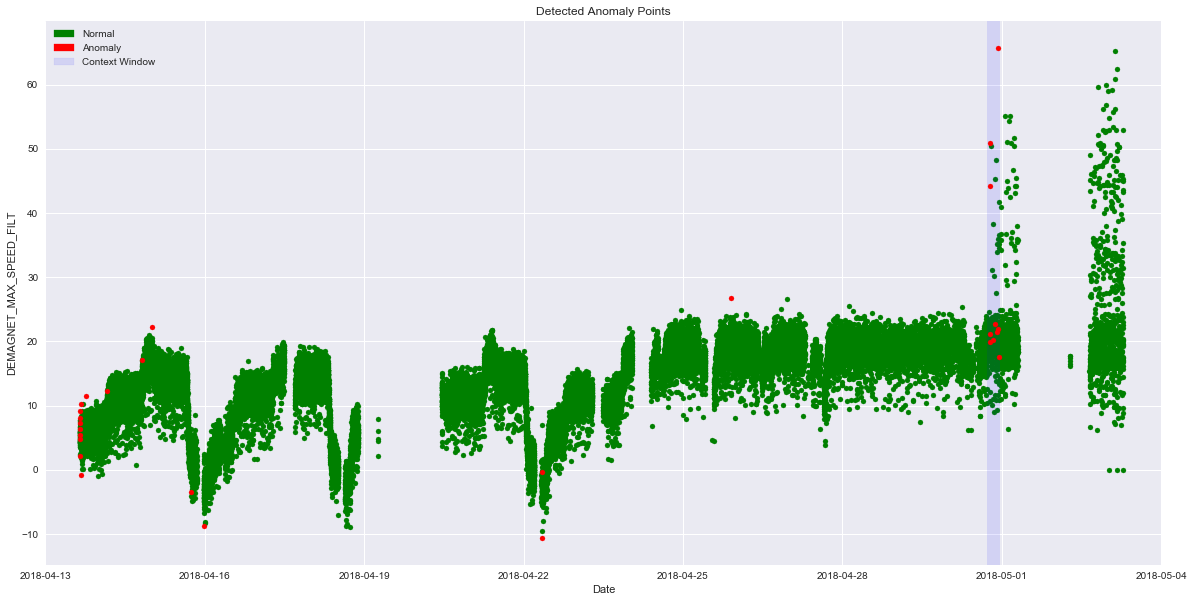

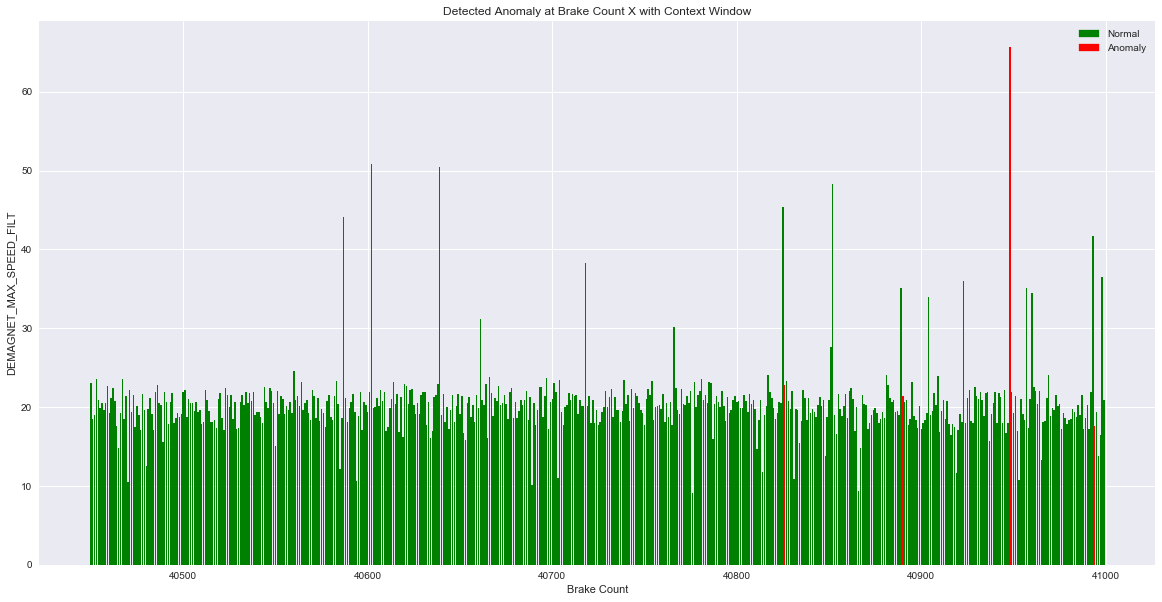

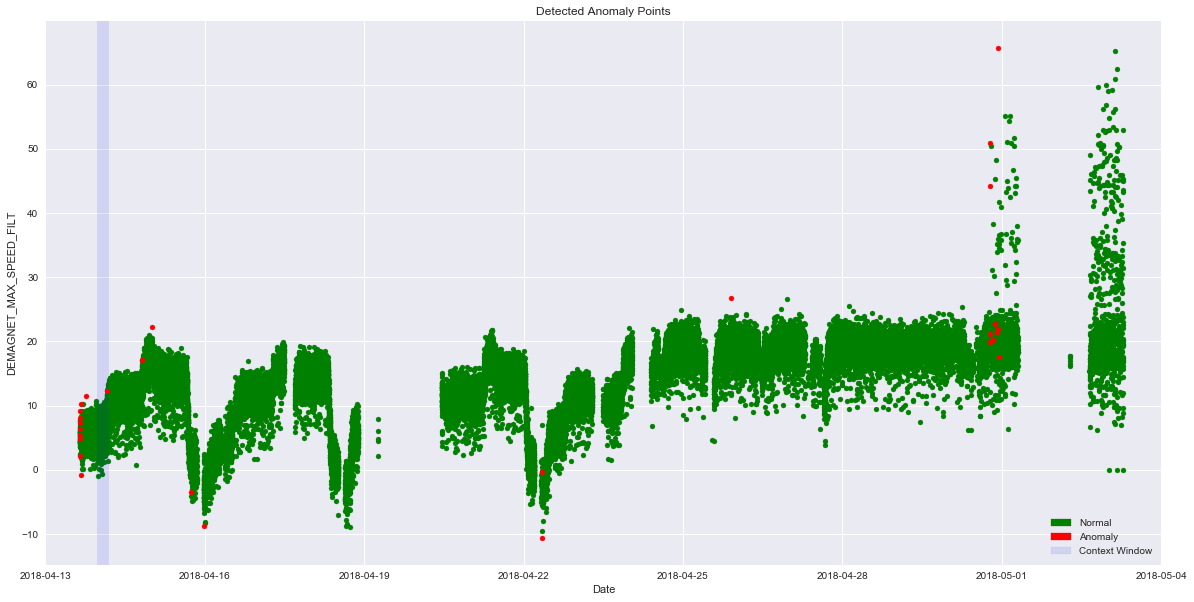

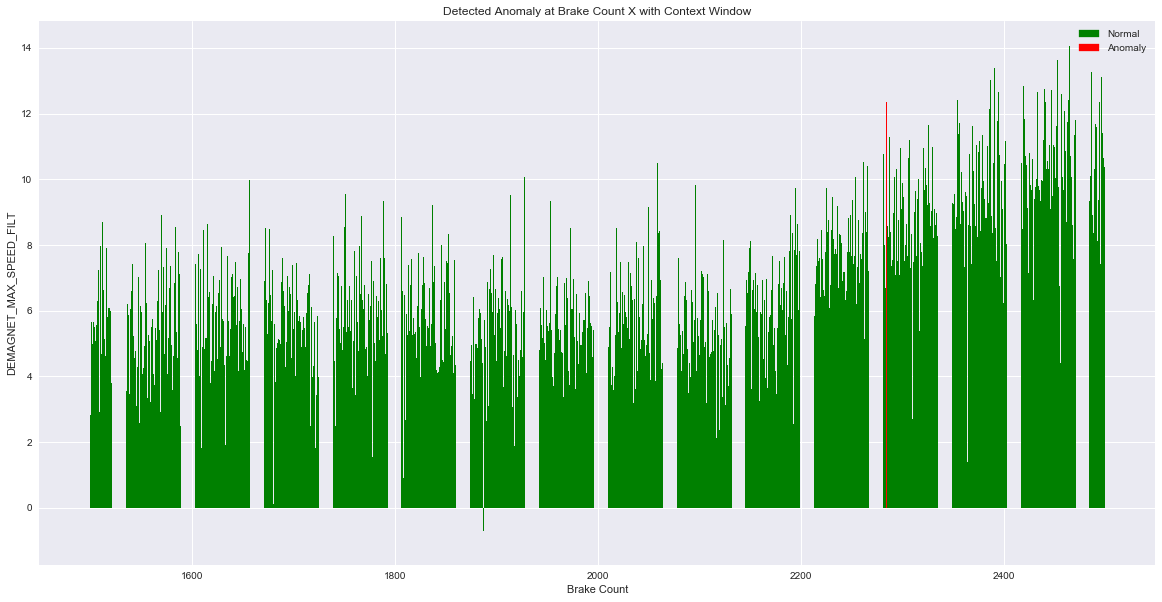

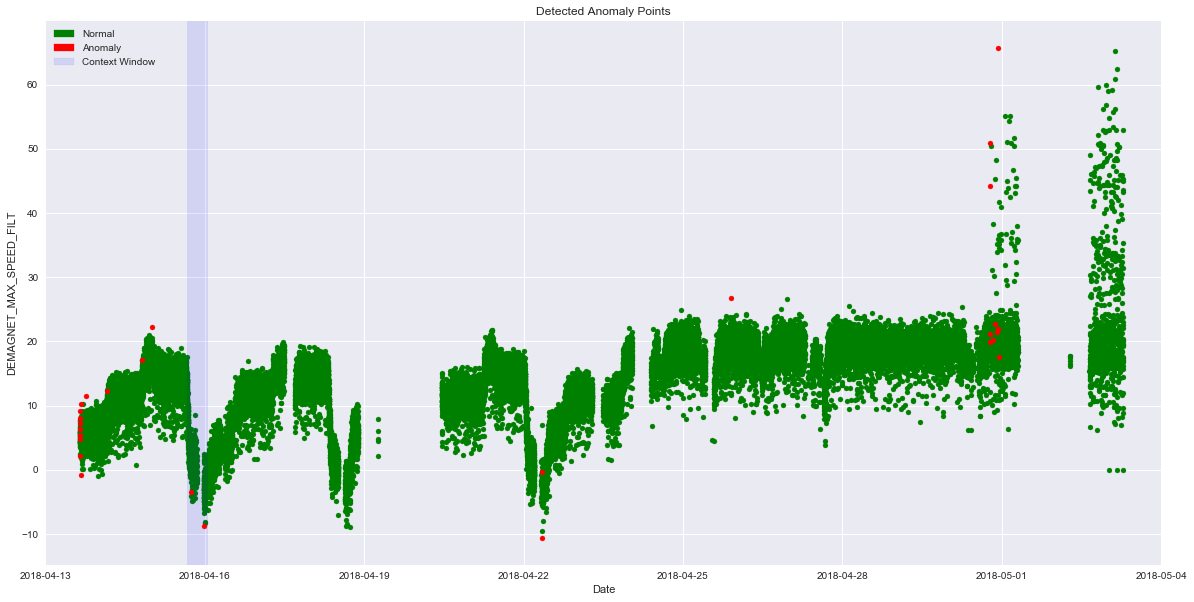

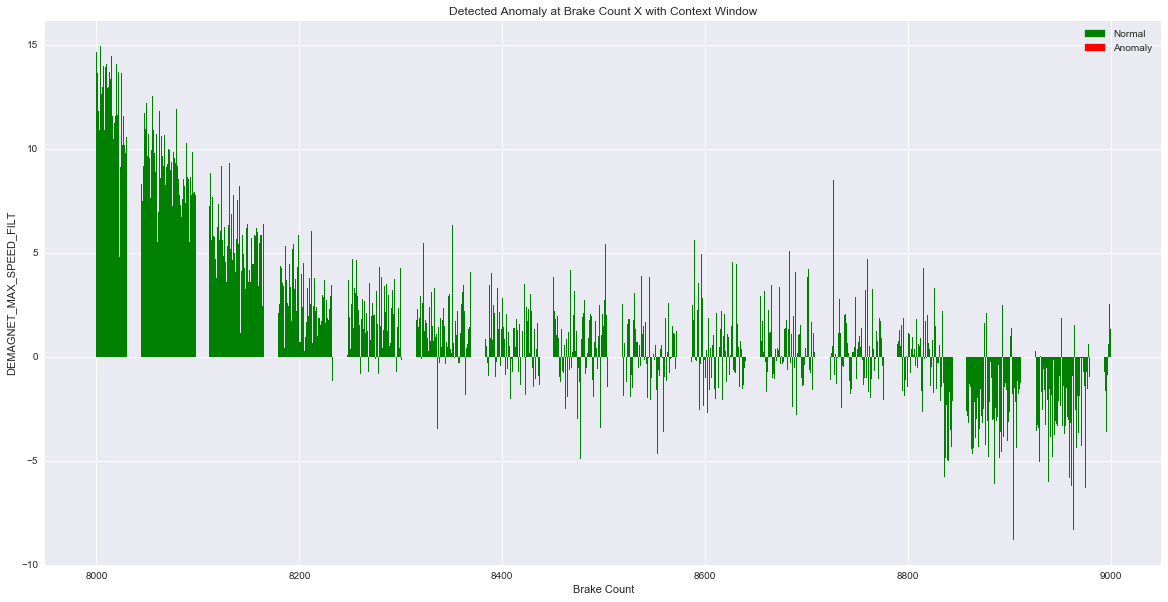

In [15]:
#plot anomaly at Brake Count 24540
plot_anomaly_context(df_anomaly, "Brake Count", "DEMAGNET_MAX_SPEED_FILT", "Detected Anomaly at Brake Count X with Context Window", 24400, 24600)

#plot anomaly at Brake Count 32473 
plot_anomaly_context(df_anomaly, "Brake Count", "DEMAGNET_MAX_SPEED_FILT", "Detected Anomaly at Brake Count X with Context Window", 32200, 32600)

#plot anomaly at Brake Count 40587, 40602, 40948
plot_anomaly_context(df_anomaly, "Brake Count", "DEMAGNET_MAX_SPEED_FILT", "Detected Anomaly at Brake Count X with Context Window", 40450, 41000)

#plot anomaly at Brake Count 40587, 40602, 40948
plot_anomaly_context(df_anomaly, "Brake Count", "DEMAGNET_MAX_SPEED_FILT", "Detected Anomaly at Brake Count X with Context Window", 1500, 2500)

plot_anomaly_context(df_anomaly, "Brake Count", "DEMAGNET_MAX_SPEED_FILT", "Detected Anomaly at Brake Count X with Context Window", 8000, 9000)